In [51]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve

### Finding the Pico's internal resistance

When disconnecting the ground from the voltage bus, measure the voltage $V_{msmt}$ and determine $R_{pico}$ using:

\begin{equation}
\frac{V_{msmt}}{3.3} = \frac{R_{pico}}{R_{ref}+R_{pico}}
\end{equation}

In [52]:
R_ref = 10
V_msmt = 2.6954 #2.143

x = symbols('x')
eq1 = Eq(x/(x+R_ref), V_msmt/3.3)
R_pico = solve(eq1, x)[0]
print(f"R_pico = {round(R_pico,2)} kOhm")

R_pico = 44.58 kOhm


## Findig the thermal resistance $R_T$ from a measured voltage

See if you can accurately predict different resistances R_T (ground side), when using a constant R_pico.

In [53]:
def R_T(V, R_ref, R_pic=R_pico):
    return round(1/((3.3/V-1)/R_ref - 1/R_pic),2)

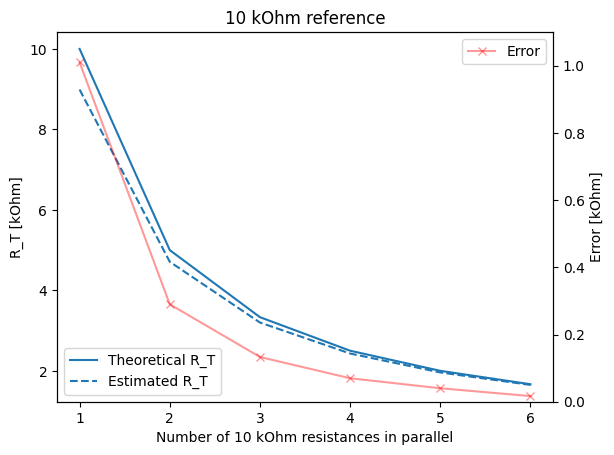

In [54]:
V_adc = [1.412272, 0.9857, 0.75817, 0.6180418, 0.5224292, 0.4523224] #+ [0.266]
R_true = [10/x for x in range(1,len(V_adc)+1)] #+ [10/14]
R_adc = [R_T(x, R_ref=10) for x in V_adc]

fig, ax = plt.subplots(1,1)
ax.plot([x+1 for x in range(len(V_adc))], R_true, color='tab:blue', label="Theoretical R_T")
ax.plot([x+1 for x in range(len(V_adc))], R_adc, color='tab:blue', linestyle='dashed', label="Estimated R_T")
ax.set_xticks([x for x in range(len(V_adc)+1)])
ax.set_xlabel('Number of 10 kOhm resistances in parallel')
ax.set_ylabel('R_T [kOhm]')
ax.legend(loc='lower left')
ax2 = ax.twinx()
ax2.plot([np.nan] + [np.abs((R_true[i]-R_adc[i])) for i in range(len(R_true))], '-x', alpha=0.4, color='red', label="Error")
ax2.set_ylabel('Error [kOhm]')
ax2.set_ylim([0,1.1])
ax2.legend()
plt.title('10 kOhm reference')
plt.plot()

error_10 = [(R_true[i]-R_adc[i]) for i in range(len(R_true))]

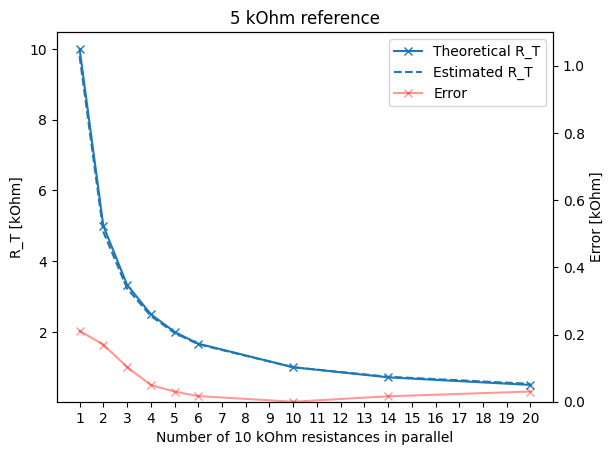

In [55]:
V_adc = [2.033098, 1.536289, 1.241078, 1.047803, 0.9053327, 0.7964492] + [0.5420046, 0.4125865, 0.3112422]
R_true = [10/x for x in range(1,7)] + [10/10, 10/14, 10/20]
R_adc = [R_T(x, R_ref=5) for x in V_adc]

fig, ax = plt.subplots(1,1)
ax.plot([x for x in range(1,7)]+[10,14,20], R_true, '-x', color='tab:blue', label="Theoretical R_T")
ax.plot([x for x in range(1,7)]+[10,14,20], R_adc, color='tab:blue', linestyle='dashed', label="Estimated R_T")
ax.set_xticks([x for x in range(20+1)])
ax.set_xlabel('Number of 10 kOhm resistances in parallel')
ax.set_ylabel('R_T [kOhm]')
ax2 = ax.twinx()
ax2.plot([x for x in range(1,7)]+[10,14,20], [np.abs(R_true[i]-R_adc[i]) for i in range(len(R_true))], '-x', alpha=0.4, color='red', label="Error")
ax2.set_ylabel('Error [kOhm]')
ax2.set_ylim([0,1.1])
plt.title('5 kOhm reference')

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2)

plt.plot()

error_5 = [(R_true[i]-R_adc[i]) for i in range(len(R_true))]

## Findint the temperature from estimated resistance $R_T$

In [56]:
t0 = 298
r0 = 5.5
beta = 3977
import math

def temp(R_T):
    temp_c = 1 / ((1 / t0) + (math.log(R_T / r0) / beta)) - 273
    temp_f = 32 + (temp_c * 9/5)   
    return temp_f

[]

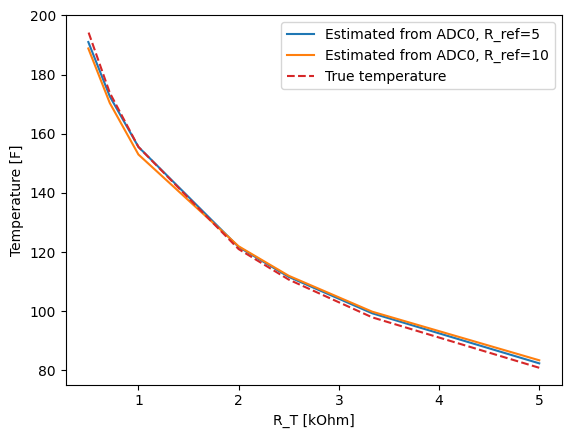

In [57]:
R_true = [10/x for x in range(2,6)] + [10/10, 10/14, 10/20]
temperature_true = [temp(r) for r in R_true]

# 5 kOhm
V_adc_5 = [1.536289, 1.241078, 1.047803, 0.9053327] + [0.5420046, 0.4125865, 0.3112422]
temperature_adc_5 = [temp(R_T(x, R_ref=5, R_pic=45)) for x in V_adc_5]

# 10 kOhm
V_adc_10 = [0.9857, 0.75817, 0.6180418, 0.5224292] + [0.3059666, 0.2305463, 0.1706086]
temperature_adc_10 = [temp(R_T(x, R_ref=10, R_pic=45)) for x in V_adc_10]

fig, ax = plt.subplots(1,1)
ax.plot(R_true, temperature_adc_5, '-', color='tab:blue', label="Estimated from ADC0, R_ref=5")
ax.plot(R_true, temperature_adc_10, '-', color='tab:orange', label="Estimated from ADC0, R_ref=10")
ax.plot(R_true, temperature_true, color='tab:red', label="True temperature", linestyle='dashed')
ax.set_xlabel('R_T [kOhm]')
ax.set_ylabel('Temperature [F]')
ax.legend()
plt.plot()

In [58]:
df = pd.DataFrame({'R_T true [kOhm]': R_true, 
                   'T true [F]': temperature_true,
                   'T (R_ref=10) [F]': temperature_adc_10,
                   'T (R_ref=5) [F]': temperature_adc_5,
                   })

df = round(df,2)
df

,R_T true [kOhm],T true [F],T (R_ref=10) [F],T (R_ref=5) [F]
0,5.00,80.86,83.39,82.36
1,3.33,97.91,99.83,99.28
2,2.50,110.68,111.97,111.60
3,2.00,120.99,121.95,121.71
4,1.00,155.55,152.99,155.55
5,0.71,173.86,170.40,172.64
6,0.50,194.49,188.84,191.03


## Comparing ADC0 and ADC1

[]

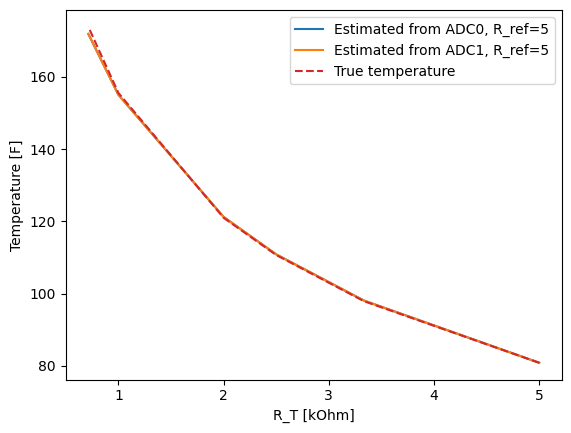

In [59]:
R_true = [10/x for x in range(2,6)] + [10/10, 10/14]#, 10/20]
temperature_true = [temp(r) for r in R_true]

# R_ref = 5 kOhm for both
V_adc0 = [1.414104, 1.161459, 0.9869243, 0.8577339] + [0.5236674, 0.4087606]#, 0.]
V_adc1 = [1.414015, 1.161533, 0.9868544, 0.8576758] + [0.5236029, 0.4087181]#, 0.]

# Change the value of R_pico to 15 kOhm
temperature_adc0 = [temp(R_T(x, R_ref=5, R_pic=15)) for x in V_adc0]
temperature_adc1 = [temp(R_T(x, R_ref=5, R_pic=15)) for x in V_adc1]

fig, ax = plt.subplots(1,1)
ax.plot(R_true, temperature_adc0, '-', color='tab:blue', label="Estimated from ADC0, R_ref=5")
ax.plot(R_true, temperature_adc1, '-', color='tab:orange', label="Estimated from ADC1, R_ref=5")
ax.plot(R_true, temperature_true, color='tab:red', label="True temperature", linestyle='dashed')
ax.set_xlabel('R_T [kOhm]')
ax.set_ylabel('Temperature [F]')
ax.legend()
plt.plot()

In [60]:
df = pd.DataFrame({'R_true [kOhm]': R_true, 
                   'V_adc [V]': V_adc0,
                   'R_adc [kOhm]': [R_T(x, R_ref=5, R_pic=15) for x in V_adc0],
                   'T(R_adc) [F]': temperature_adc0,
                   'T(R_true) [F]': temperature_true,
                   'Absolute error [F]': [np.abs((temperature_true[i]-temperature_adc0[i])) for i in range(len(temperature_adc0))],
                   })

df = round(df,2)
df

,R_true [kOhm],V_adc [V],R_adc [kOhm],T(R_adc) [F],T(R_true) [F],Absolute error [F]
0,5.00,1.41,5.00,80.86,80.86,0.00
1,3.33,1.16,3.32,98.09,97.91,0.17
2,2.50,0.99,2.49,110.86,110.68,0.18
3,2.00,0.86,1.99,121.23,120.99,0.24
4,1.00,0.52,1.01,155.03,155.55,0.53
5,0.71,0.41,0.74,171.88,173.86,1.98
